# Classyfing YouTube videos using tags, number of likes, comments and views


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals


import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

d:\miniconda3\envs\youtube-classification\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\miniconda3\envs\youtube-classification\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\miniconda3\envs\youtube-classification\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\miniconda3\envs\youtube-classification\lib\site-pack

In [2]:
from cvs_reader import load_dataframe
from dataframe_creator import create_seperate_columns

# Get dataframes with tags and category_id as columns
ca_csvpath = 'data/CAvideos.csv'
us_csvpath = 'data/USvideos.csv'
gb_csvpath = 'data/GBvideos.csv'

youtube_dfs = [load_dataframe(ca_csvpath, ['tags', 'category_id', 'likes', 'views', 'comment_count'])]
youtube_dfs += [load_dataframe(us_csvpath, ['tags', 'category_id', 'likes', 'views', 'comment_count'])]
youtube_dfs += [load_dataframe(gb_csvpath, ['tags', 'category_id', 'likes', 'views', 'comment_count'])]

# Concat three dataframes into one
youtube_df = pd.concat(youtube_dfs, ignore_index=True)
youtube_df = youtube_df.dropna()
youtube_df.head()

,tags,category_id,likes,views,comment_count
0,Eminem|Walk|On|Water|Aftermath/Shady/Interscop...,10,787425,17158579,125882
1,plush|bad unboxing|unboxing|fan mail|idubbbztv...,23,127794,1014651,13030
2,racist superman|rudy|mancuso|king|bach|racist|...,23,146035,3191434,8181
3,ryan|higa|higatv|nigahiga|i dare you|idy|rhpc|...,24,132239,2095828,17518
4,edsheeran|ed sheeran|acoustic|live|cover|offic...,10,1634130,33523622,85067


In [3]:
# Remove 'none' and duplicated values from dataframe
youtube_df = youtube_df[youtube_df['tags']!='[none]']
youtube_df = youtube_df.drop_duplicates(subset='tags')
youtube_df = youtube_df.reset_index(drop=True)
youtube_df.head()

,tags,category_id,likes,views,comment_count
0,Eminem|Walk|On|Water|Aftermath/Shady/Interscop...,10,787425,17158579,125882
1,plush|bad unboxing|unboxing|fan mail|idubbbztv...,23,127794,1014651,13030
2,racist superman|rudy|mancuso|king|bach|racist|...,23,146035,3191434,8181
3,ryan|higa|higatv|nigahiga|i dare you|idy|rhpc|...,24,132239,2095828,17518
4,edsheeran|ed sheeran|acoustic|live|cover|offic...,10,1634130,33523622,85067


In [4]:
# delete some categories because of lack of data
to_delete = [2, 15, 19, 29, 30, 43]
for cat in to_delete:
    youtube_df = youtube_df[youtube_df.category_id != cat]
youtube_df.head()

,tags,category_id,likes,views,comment_count
0,Eminem|Walk|On|Water|Aftermath/Shady/Interscop...,10,787425,17158579,125882
1,plush|bad unboxing|unboxing|fan mail|idubbbztv...,23,127794,1014651,13030
2,racist superman|rudy|mancuso|king|bach|racist|...,23,146035,3191434,8181
3,ryan|higa|higatv|nigahiga|i dare you|idy|rhpc|...,24,132239,2095828,17518
4,edsheeran|ed sheeran|acoustic|live|cover|offic...,10,1634130,33523622,85067


In [5]:
from sklearn.utils import resample


# Spliting dataframe into several dfs based on category_id
dfs = [x for _, x in youtube_df.groupby('category_id')]

# getting 2000 samples from each category
resampled_dfs = []
for df in dfs:
    if df.shape[0] < 2000:
        resampled_dfs += [resample(df, n_samples=2000)]
    else:
        resampled_dfs += [df.sample(n=2000)]
    
youtube_df = pd.concat(resampled_dfs, axis=0, ignore_index=True)
youtube_df.head()

,tags,category_id,likes,views,comment_count
0,CG Record|CGI|Animation|Computer Graphics|comp...,1,500,31112,67
1,Trailer|Hugh Jackman|Michelle Williams|Zac Efr...,1,3086,121074,266
2,Rooster Teeth|RT|animation|television|filmmaki...,1,2184,97568,590
3,Idoles|idoles saison 4 épisode 7|idoles saison...,1,2375,120958,724
4,anna|akana|ana|annaakana|the moment i threw yo...,1,26441,170279,1576


In [6]:
# mapping remaining category numbers to ordered integers
new_categories_dict = {1:1, 10:2, 17:3, 20:4, 22:5, 23:6, 24:7, 25:8, 26:9, 27:10, 28:11}
reversed_new_categories_dict = {value:key for key, value in new_categories_dict.items()}
categories = youtube_df['category_id']
youtube_df['category_id'] = categories.map(new_categories_dict)
youtube_df.head()

,tags,category_id,likes,views,comment_count
0,CG Record|CGI|Animation|Computer Graphics|comp...,1,500,31112,67
1,Trailer|Hugh Jackman|Michelle Williams|Zac Efr...,1,3086,121074,266
2,Rooster Teeth|RT|animation|television|filmmaki...,1,2184,97568,590
3,Idoles|idoles saison 4 épisode 7|idoles saison...,1,2375,120958,724
4,anna|akana|ana|annaakana|the moment i threw yo...,1,26441,170279,1576


In [7]:
from vocab_handler import get_tags_frequency, get_tags_vocab, get_tags_vocab_as_dict


tag_frequency = get_tags_frequency(youtube_df['tags']) # returns tag as key and tag frequency as value
lists = sorted(tag_frequency.items())

lists[:10]

[('', 5),
 (" 'Gandarrappido: The Revenger Squad ", 1),
 (' 070118 💖', 1),
 (' 080118 💖', 0),
 (' 101217 💚', 2),
 (' 140118 💖', 2),
 (' 150118 💖', 0),
 (' 2018', 1),
 (' 210118 💖', 0),
 (' 220118 💖', 1)]

In [8]:
pruned_vocab = get_tags_vocab(tag_frequency, 5) #Returns tags vocab
vocab_di = get_tags_vocab_as_dict(pruned_vocab)

In [9]:
from sklearn.preprocessing import StandardScaler


# Perfroming normalization on integer datas
youtube_df['average'] = (youtube_df['likes'] + youtube_df['comment_count'] + youtube_df['views'])/3
scaler = StandardScaler()


youtube_df[['likes', 'comment_count', 'views', 'average']] = scaler.fit_transform(youtube_df[['likes', 'comment_count', 'views', 'average']])


In [10]:
max_of_tags = 96
 
# Create a dataframe by spliting each tag by '|'
youtube_df = create_seperate_columns(youtube_df, max_of_tags, 'tags')
youtube_df.head()

,category_id,likes,views,comment_count,average,tag_0,tag_1,tag_2,tag_3,tag_4,...,tag_86,tag_87,tag_88,tag_89,tag_90,tag_91,tag_92,tag_93,tag_94,tag_95
0,1,-0.291623,-0.285019,-0.227452,-0.288524,CG Record,CGI,Animation,Computer Graphics,computer Animation,...,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags
1,1,-0.256619,-0.237625,-0.211640,-0.241197,Trailer,Hugh Jackman,Michelle Williams,Zac Efron,Zendaya,...,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags
2,1,-0.268828,-0.250008,-0.185897,-0.253487,Rooster Teeth,RT,animation,television,filmmaking,...,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags
3,1,-0.266243,-0.237686,-0.175250,-0.241385,Idoles,idoles saison 4 épisode 7,idoles saison 4,Even Prod,idoles 7,...,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags
4,1,0.059507,-0.211702,-0.107555,-0.203503,anna,akana,ana,annaakana,the moment i threw your toothbrush away,...,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags


In [11]:
# One hot encoding tags
def one_hot(df, non_one_hot_columns):
    future_df = []
    col_row_dict = {}
    
    for i in range(0, 22000):
        for col in df.columns:
            if col in non_one_hot_columns:
                col_row_dict[col] = df[col][i]
            elif df[col][i] in pruned_vocab:
                    col_row_dict[df[col][i]] = 1.0
        future_df.append(col_row_dict)
        col_row_dict = {}
        
    return future_df

In [12]:
one_hot_list = one_hot(youtube_df, ['category_id', 'comment_count', 'likes', 'views', 'average'])
youtube_df = pd.DataFrame(one_hot_list)
youtube_df.fillna(0.0, inplace = True)
youtube_df.head()

,category_id,likes,views,comment_count,average,Animation,Oscar,Trailer,Hugh Jackman,Michelle Williams,...,gtx,xiaomi,google io,game console,mystery boxes,eBay,AsapSCIENCE,best science videos,oneplus 6 launch,mi mix
0,1,-0.291623,-0.285019,-0.227452,-0.288524,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,-0.256619,-0.237625,-0.211640,-0.241197,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,-0.268828,-0.250008,-0.185897,-0.253487,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,-0.266243,-0.237686,-0.175250,-0.241385,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.059507,-0.211702,-0.107555,-0.203503,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
from input_generator import generate_dataset


# Creating train,validation and test examples from tags and labels dataframe
(train_ds, train_lb), (val_ds, val_lb), (test_ds, test_lb) = generate_dataset(youtube_df, 'category_id')

In [17]:
from tensorflow.keras.regularizers import l2


model = tf.keras.Sequential([
    layers.Dense(300, kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001), activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(500,kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001), activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(500,kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001) , activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(100,kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001), activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(12,kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001), activation='softmax')])

nadam = keras.optimizers.Nadam(lr=0.001)

model.compile(optimizer=nadam,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              )

history = model.fit(train_ds.values, train_lb.values,
                    batch_size=32,
                    epochs=5,
                    validation_data=(val_ds.values, val_lb.values))


Train on 13200 samples, validate on 4400 samples
Epoch 1/5
13200/13200 [==============================] - 54s 4ms/sample - loss: 1.3924 - acc: 0.6114 - val_loss: 0.8403 - val_acc: 0.7934
Epoch 2/5
13200/13200 [==============================] - 56s 4ms/sample - loss: 0.7624 - acc: 0.8251 - val_loss: 0.8119 - val_acc: 0.8157
Epoch 3/5
13200/13200 [==============================] - 49s 4ms/sample - loss: 0.6179 - acc: 0.8726 - val_loss: 0.8599 - val_acc: 0.8100
Epoch 4/5
13200/13200 [==============================] - 53s 4ms/sample - loss: 0.5403 - acc: 0.8914 - val_loss: 0.8949 - val_acc: 0.8177
Epoch 5/5
13200/13200 [==============================] - 52s 4ms/sample - loss: 0.5108 - acc: 0.9048 - val_loss: 0.9141 - val_acc: 0.8173


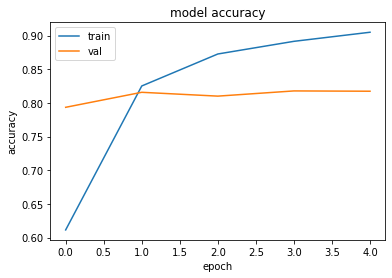

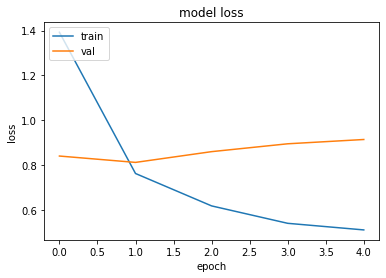

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

plt.plot(acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
results = model.evaluate(test_ds, test_lb)

print(results)

In [ ]:
from sklearn.metrics import classification_report

predictions = model.predict(test_ds)
print(classification_report(test_lb, np.argmax(predictions, axis=1)))

In [ ]:
from tag_handler import get_category_title_dict


cat_tit_dict = get_category_title_dict('data/json/CA_category_id.json')
cat_tit_dict.update(get_category_title_dict('data/json/US_category_id.json'))
cat_tit_dict.update(get_category_title_dict('data/json/GB_category_id.json'))

In [ ]:
for i in range(30, 40):
    y_pred = reversed_new_categories_dict[np.argmax(predictions[i])]
    label = reversed_new_categories_dict[test_lb.values[i]]
    print('""""""""""""""""""""""""""""""""""""""""""""""""')
    print('predict:{}'.format(cat_tit_dict[str(y_pred)]))
    print('true label:{}'.format(cat_tit_dict[str(label)]))